In [1]:
import copy
import json

import gym
import matplotlib.pyplot as plt
import numpy as np

from src.approx import PolyFeatures
from src.models import EnvModel, ModelWrapper
from src.qlearning import Qlearner
from src.util import evaluate
from src.util import run_learner, smooth, plot_mc_value, generate_data
%matplotlib inline

In [2]:
env = gym.make('MountainCarLong-v0')
eval_env = copy.deepcopy(env)


# Model- free Learner

Create a linear Q-learner. This Q-learning agent uses linear function approximation with polynomial features to approximate the value function.

In [40]:
# Create 5th degree polynomial features
feature_map = PolyFeatures(env, 5)
qlearner = Qlearner(feature_map, n_actions = env.action_space.n, lr=0.05, discount=0.99, eps=0.1)

Solve the environment:

In [41]:
mf_log = run_learner(env, qlearner, 500, eval_env, log_steps=1000)

Episode 0 - total reward -5000.0
Episode 1 - total reward -365.0
Episode 2 - total reward -1929.0
Episode 3 - total reward -351.0
Episode 4 - total reward -338.0
Episode 5 - total reward -279.0
Episode 6 - total reward -250.0
Episode 7 - total reward -273.0
Episode 8 - total reward -314.0
Episode 9 - total reward -246.0
Episode 10 - total reward -240.0
Episode 11 - total reward -237.0
Episode 12 - total reward -163.0
Episode 13 - total reward -226.0
Episode 14 - total reward -230.0
Episode 15 - total reward -162.0
Episode 16 - total reward -227.0
Episode 17 - total reward -231.0
Episode 18 - total reward -157.0
Episode 19 - total reward -154.0
Episode 20 - total reward -167.0
Episode 21 - total reward -156.0
Episode 22 - total reward -169.0
Episode 23 - total reward -153.0
Episode 24 - total reward -164.0
Episode 25 - total reward -161.0
Episode 26 - total reward -162.0
Episode 27 - total reward -161.0
Episode 28 - total reward -156.0
Episode 29 - total reward -161.0
Episode 30 - total

In [46]:
with open('../data/model_free.json', 'w') as f:
    json.dump(mf_log, f)

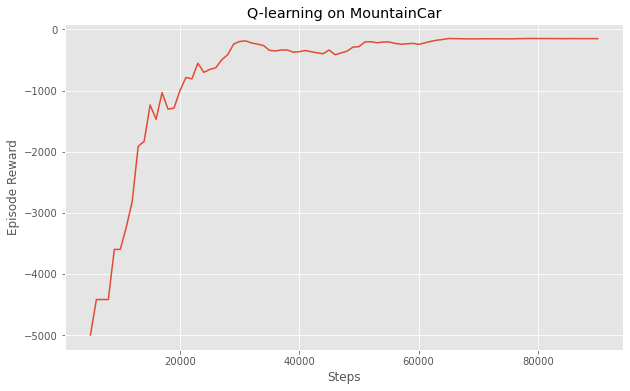

In [61]:
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
plt.title('Q-learning on MountainCar')
plt.xlabel('Steps')
plt.ylabel('Episode Reward')
plt.plot(mf_log['steps'][4:], smooth(mf_log['rewards'],5), label='model-free')
plt.savefig('../images/qlearning.png')

In [68]:
fig = plt.figure(figsize=(10,6))
ax=plot_mc_value(env.observation_space, qlearner.phi, qlearner.weights, fig)
plt.savefig('../images/vfun.png')

TypeError: plot_mc_value() takes 3 positional arguments but 4 were given

<Figure size 720x432 with 0 Axes>

# Model Based Learning

In [48]:
def run_model_based(real_env, max_data):
    log = {
        'nsamples': [],
        'model_reward': [],
        'env_reward': [],
        'model_error': []
    }
    test_set = generate_data(env, 10000, lambda s: real_env.action_space.sample())
    test_states, test_actions, test_rewards, test_nstates, test_done = tuple(map(np.array, zip(*test_set)))
    for n_samples in range(1000, max_data, 1000):
        # generate data and train model
        train_set = generate_data(real_env, n_samples, lambda s: real_env.action_space.sample())
        states, actions, rewards, nstates, done = tuple(map(np.array, zip(*train_set)))
        feature_map = PolyFeatures(env, 5)
        model = EnvModel(feature_map)
        model.train(states, actions, rewards, nstates)
        # wrap model in gym interface and train qlearner on model environment
        model_env = ModelWrapper(model)
        mb_qlearner = Qlearner(feature_map, n_actions = real_env.action_space.n, lr=0.05, discount=0.99, eps=0.1)
        run_learner(model_env, mb_qlearner, 500, real_env, log_steps=-1)
        # evaluate trained learner on model env
        model_reward = evaluate(model_env, mb_qlearner, 10)[-1]
        # evaluate trained learner on real env
        reward = evaluate(real_env, mb_qlearner, 10)[-1]
        log['nsamples'].append(n_samples)
        log['model_reward'].append(model_reward)
        log['env_reward'].append(reward)
        log['model_error'].append(float(np.mean((model.predict(test_states, test_actions)[0] - test_nstates)**2)))
    return log

In [49]:
mb_log = run_model_based(eval_env, 20000)

Episode 0 - total reward -1746.0
Episode 1 - total reward -226.0
Episode 2 - total reward -259.0
Episode 3 - total reward -246.0
Episode 4 - total reward -186.0
Episode 5 - total reward -267.0
Episode 6 - total reward -174.0
Episode 7 - total reward -86.0
Episode 8 - total reward -100.0
Episode 9 - total reward -110.0
Episode 10 - total reward -157.0
Episode 11 - total reward -267.0
Episode 12 - total reward -135.0
Episode 13 - total reward -153.0
Episode 14 - total reward -77.0
Episode 15 - total reward -153.0
Episode 16 - total reward -107.0
Episode 17 - total reward -104.0
Episode 18 - total reward -88.0
Episode 19 - total reward -86.0
Episode 20 - total reward -94.0
Episode 21 - total reward -177.0
Episode 22 - total reward -148.0
Episode 23 - total reward -79.0
Episode 24 - total reward -112.0
Episode 25 - total reward -118.0
Episode 26 - total reward -155.0
Episode 27 - total reward -137.0
Episode 28 - total reward -79.0
Episode 29 - total reward -71.0
Episode 30 - total reward -

In [54]:
mb_log_copy = {}
for k,v in mb_log.items():
    mb_log_copy[k] = list(map(float, v))

In [55]:
with open('../data/model_based.json', 'w') as f:
    json.dump(mb_log_copy, f)

In [70]:
with open('../data/model_based.json', 'r') as f:
    mb_log_copy2 = json.load(f)

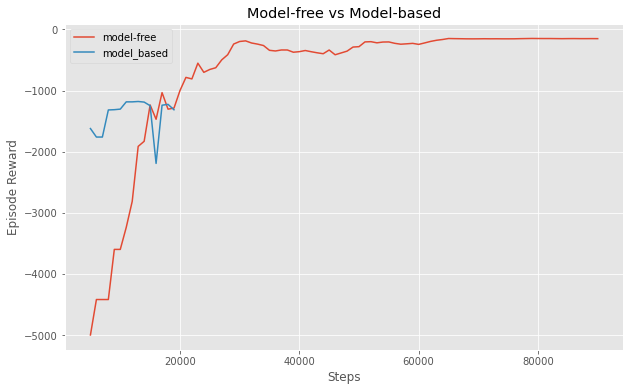

In [71]:
plt.figure(figsize=(10,6))
plt.title('Model-free vs Model-based')
plt.xlabel('Steps')
plt.ylabel('Episode Reward')
plt.plot(mf_log['steps'][4:], smooth(mf_log['rewards'],5), label='model-free')
plt.plot(mb_log_copy2['nsamples'][4:], smooth(mb_log_copy2['env_reward'],5), label='model_based')
plt.legend()
plt.savefig('../images/mfvsmb2.png')